In [39]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

'''Visualisation'''
import matplotlib.pyplot as plt
import seaborn as sns

'''Manipulating Data and Model Building'''
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [40]:
DIR = '/kaggle/input/pest-classification-ip102-dataset/new' #Creating a master directory
classes = [i for i in os.listdir(DIR) if '.' not in i]                     #Creating classes out of the required folders
classes
label = []
path = []

for dirname, _,filenames in os.walk(DIR):                    
    for filename in filenames:                                 
         if os.path.splitext(filename)[-1].lower() in ['.jpg', '.jpeg', '.png']:
            # Check if the directory name does not contain 'GT'
            if 'GT' not in dirname.split(os.path.sep):
                # Append the directory name to the label
                label.append(os.path.split(dirname)[-1])
                # Append the full file path to the path list
                path.append(os.path.join(dirname, filename))
# Ready to create the df
df = pd.DataFrame(columns=['path','label'])
df['path']=path
df['label']=label

In [41]:
keep_classes = ['Locustoidea','aphids']

# Filter the dataframe to keep only the rows with the labels you want
df = df[df['label'].isin(keep_classes)]


In [42]:
print(df['label'].unique())

['Locustoidea' 'aphids']


In [43]:
# Count the number of images in each class
class_counts = df['label'].value_counts()

# Display the counts based on the order of keep_classes
for class_name in keep_classes:
    count = class_counts.get(class_name, 0)
    print(f"Class: {class_name}, Number of Images: {count}")


Class: Locustoidea, Number of Images: 836
Class: aphids, Number of Images: 2456


In [44]:
train_df, test_df = train_test_split(df, train_size=0.8, stratify=df['label'], shuffle=True, random_state=42)


In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=10,
    validation_split=0.2  # Set validation split directly here
)

# Define ImageDataGenerator for test (without augmentation)
test_datagen = ImageDataGenerator()

# Adjust the target_size to (224, 224) for VGG16
target_size = (224, 224)

# Training data generator
train_images = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=target_size,
    color_mode='rgb',
    class_mode='sparse',  # Assumes labels are integers
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'  # Set training subset
)

# Validation data generator
val_images = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=target_size,
    color_mode='rgb',
    class_mode='sparse',  # Assumes labels are integers
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'  # Set validation subset
)

# Test data generator
test_images = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=target_size,
    color_mode='rgb',
    class_mode='sparse',  # Assumes labels are integers
    batch_size=32,
    shuffle=False  # No need to shuffle the test set
)

Found 2107 validated image filenames belonging to 2 classes.
Found 526 validated image filenames belonging to 2 classes.
Found 659 validated image filenames belonging to 2 classes.


In [46]:
from tensorflow.keras.callbacks import EarlyStopping
# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',      # Which metric to monitor
    min_delta=0.01,           # Minimum change to qualify as an improvement
    patience=10,              # How many epochs to wait before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)



In [47]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD  # Import SGD optimizer

inputs = pretrained_model.input

# Flatten the output of VGG16
x = tf.keras.layers.Flatten()(pretrained_model.output)
outputs = tf.keras.layers.Dense(len(keep_classes), activation='softmax')(x)

# Create a new model
model = Model(inputs=inputs, outputs=outputs)

# Define loss function and optimizer
criterion = SparseCategoricalCrossentropy()
 # Define SGD optimizer
model.compile(
    optimizer='adam',  # Use the defined optimizer
    loss=criterion,
    metrics=['accuracy']
)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [49]:
history = model.fit(
    train_images, 
    validation_data=val_images,
    epochs=50,
    callbacks=[early_stopping],  # Add early stopping callback
    verbose=1
)

Epoch 1/50
66/66 [==============================] - 12s 136ms/step - loss: 0.2408 - accuracy: 0.9060 - val_loss: 0.1304 - val_accuracy: 0.9563
Epoch 2/50
66/66 [==============================] - 8s 127ms/step - loss: 0.0968 - accuracy: 0.9706 - val_loss: 0.1103 - val_accuracy: 0.9620
Epoch 3/50
66/66 [==============================] - 9s 134ms/step - loss: 0.0754 - accuracy: 0.9758 - val_loss: 0.1030 - val_accuracy: 0.9620
Epoch 4/50
66/66 [==============================] - 9s 133ms/step - loss: 0.0630 - accuracy: 0.9810 - val_loss: 0.0906 - val_accuracy: 0.9753
Epoch 5/50
66/66 [==============================] - 8s 120ms/step - loss: 0.0507 - accuracy: 0.9820 - val_loss: 0.0877 - val_accuracy: 0.9772
Epoch 6/50
66/66 [==============================] - 8s 128ms/step - loss: 0.0454 - accuracy: 0.9877 - val_loss: 0.0862 - val_accuracy: 0.9772
Epoch 7/50
66/66 [==============================] - 9s 131ms/step - loss: 0.0392 - accuracy: 0.9891 - val_loss: 0.0856 - val_accuracy: 0.9772
Epoch

21/21 [==============================] - 3s 95ms/step


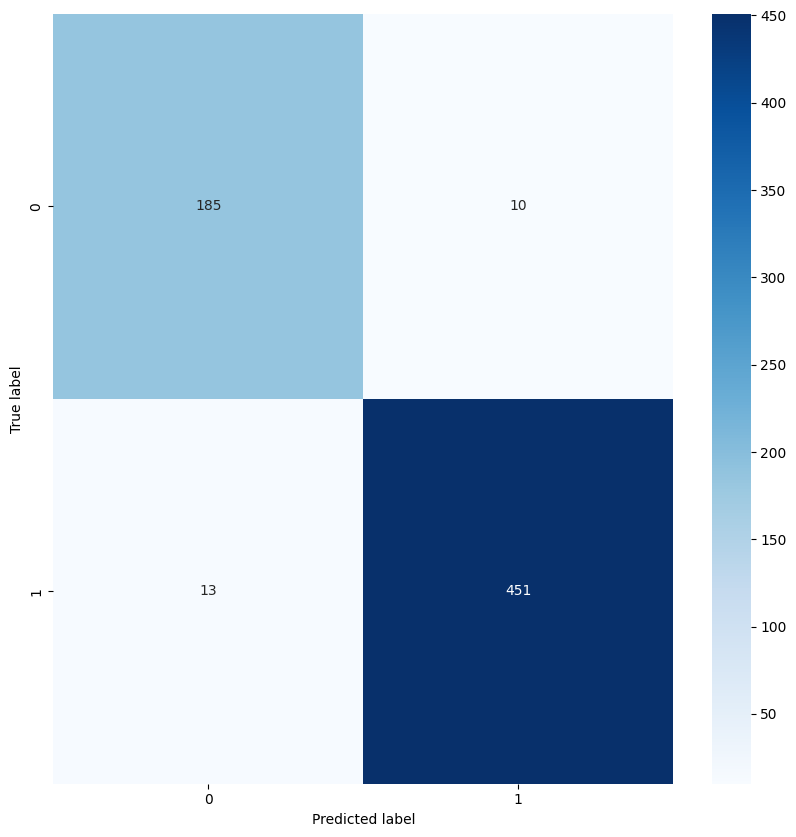

In [50]:
# Evaluate the model on the test set
y_true = test_images.classes
y_pred_probs = model.predict(test_images)
y_pred = np.argmax(y_pred_probs, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [53]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Precision: 0.92
Recall: 0.92
F1 Score: 0.92


In [51]:
def predict_image(model, img_path):
    # Load the image
    img = image.load_img(img_path, target_size=(224, 224))  # Update target_size
    
    # Convert the image to a numpy array
    img_array = image.img_to_array(img)
    
    # Expand dimensions so the image has shape (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Preprocess the image
    img_array = preprocess_input(img_array)
    
    # Use the model to make a prediction
    prediction = model.predict(img_array)
    
    # Get the class with the highest predicted probability
    predicted_class = np.argmax(prediction[0])
    
    # Get the name of the predicted class
    predicted_class_name = keep_classes[predicted_class]
    
    # Get the predicted probability of the predicted class
    confidence = prediction[0][predicted_class]
    
    return predicted_class_name, confidence


In [61]:
img_path = '/kaggle/input/pest-classification-ip102-dataset/new/Ampelophaga/43864.jpg'  # Replace with the path to your image
predicted_class_name, confidence = predict_image(model, img_path)
print(f'Predicted class: {predicted_class_name}')
print(f'Confidence: {confidence}')

1/1 [==============================] - 0s 22ms/step
Predicted class: aphids
Confidence: 0.7709862589836121


In [57]:
model.save("/kaggle/working/PestFinal.h5")

In [58]:
import tensorflow as tf

# Load the Keras model from the H5 file
model_path = '//kaggle/working/PestFinal.h5'
loaded_model = tf.keras.models.load_model(model_path)

# Convert the loaded Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

# Write the TensorFlow Lite model to a file
with open('Pestmobile.tflite', 'wb') as f:
    f.write(tflite_model)
